In [ ]:
import os, torch
from sklearn.model_selection import train_test_split
import pickle
import torch_geometric.transforms as T
import numpy as np
from torch_geometric.nn.models import Node2Vec
from torch_geometric.data import DataLoader
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
GCNConv._orig_propagate = GCNConv.propagate

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch_geometric.explain import GNNExplainer, Explainer


epochs = int(os.getenv("EPOCHS", 10))  # Default to 10 if not provided
learning_rate = float(os.getenv("LEARNING_RATE", 0.001))  # Default to 0.001
hidden_c = int(os.getenv("HIDDEN_C", 16))  # Default to 16
random_seed = int(os.getenv("RANDOM_SEED", 42))  # Default to 42
bins = [int(i) for i in os.getenv("BINS", "400 800 1300 2100 3000 3700 4700 7020 9660").split(' ')]  # Default to [1000, 3000, 5000]
bins = [int(i) for i in os.getenv("BINS", "3000").split(' ')]  # Default to [1000, 3000, 5000]
num_layers = int(os.getenv("NUM_LAYERS", 5))  # Default to 5
nh = int(os.getenv("NUM_HEADS", 10))
gat = int(os.getenv("GAT", 0))
api_key = os.getenv("API_KEY", None)
graph_num = os.getenv("GRAPH_NUM", 2)
dropout_p = float(os.getenv("DROPOUT", 0.5))

bins = torch.tensor(bins, device='cuda' if torch.cuda.is_available() else 'cpu')

graph_num = 20

model_name = 'woven-yogurt-280'  # Replace with your model name
weight_prefix = 'best_accuracy'  # Replace with your weight prefix

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using CUDA device: {torch.cuda.get_device_name(0)}", flush = True)
else:
    device = torch.device('cpu')
    print("Using CPU", flush = True)

device = 'cpu'

with open(f'../data/graphs/{graph_num}/linegraph_tg.pkl', 'rb') as f:
    data = pickle.load(f)

data.edge_index = data.edge_index.contiguous()
data.x = data.x.contiguous()
data.y = data.y.contiguous()

# Define or import the GCN class
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(random_seed)
        self.conv1 = GCNConv(data.num_features, hidden_channels, improved = True, cached = True)
        conv2_list = []
        hc = hidden_channels
        # for _ in range(num_layers):
        #     conv2_list.append(
        #         GCNConv(hc, hc)
        #     )
            # hc //= 2
        # self.conv2 = torch.nn.ModuleList(conv2_list)
        self.conv3 = GCNConv(hc, len(bins) + 1, cached = True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=dropout_p, training=self.training)
        # for conv in self.conv2:
        #     x = conv(x, edge_index)
        #     x = F.relu(x)
        #     x = F.dropout(x, p=dropout_p, training=self.training)
        x = self.conv3(x, edge_index)
        return x


# Load the model with the GCN class
model = torch.load(f'../data/graphs/{graph_num}/models/{model_name}.pt', map_location=device)
model = model.to(device)

model.load_state_dict(torch.load(f'../data/graphs/{graph_num}/models/{model_name}_{weight_prefix}.pt', map_location=device))


In [ ]:
def stratified_split(data, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """Splits data into train, validation, and test sets, stratifying by y > 0."""

    # Create a boolean mask for nodes where y > 0
    positive_mask = data.y > 0

    # Get indices of positive and negative nodes
    positive_indices = positive_mask.nonzero(as_tuple=False).squeeze()
    negative_indices = (~positive_mask).nonzero(as_tuple=False).squeeze()

    # Split positive indices
    pos_train_idx, pos_temp_idx = train_test_split(positive_indices, train_size=train_ratio, random_state=random_seed)  # Adjust random_state for consistent splits
    pos_val_idx, pos_test_idx = train_test_split(pos_temp_idx, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=random_seed)

    # Split negative indices
    neg_train_idx, neg_temp_idx = train_test_split(negative_indices, train_size=train_ratio, random_state=random_seed)
    neg_val_idx, neg_test_idx = train_test_split(neg_temp_idx, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=random_seed)

    # Combine indices
    train_idx = torch.cat([pos_train_idx, neg_train_idx])
    val_idx = torch.cat([pos_val_idx, neg_val_idx])
    test_idx = torch.cat([pos_test_idx, neg_test_idx])

    # Create masks
    train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

    train_mask[train_idx] = True
    val_mask[val_idx] = True
    test_mask[test_idx] = True

    data.train_mask = train_mask
    data.val_mask = val_mask
    data.test_mask = test_mask

    return data

data.edge_index = data.edge_index.contiguous()
data.x = data.x.contiguous()
data.y = data.y.contiguous()

print(data.x.shape, data.edge_index.shape, data.y.shape, flush = True)

data = stratified_split(data)


In [ ]:
from torch_geometric.explain import GNNExplainer, Explainer

explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=1),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type=None,
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)


In [ ]:
mask = data.val_mask.squeeze() & (data.y > 0).squeeze()

node_idx = torch.nonzero(mask, as_tuple=True)[0]


In [ ]:
out = model(data.x.to(device), data.edge_index.to(device))
pred = out.argmax(dim=1)


In [ ]:
used_feats = []
scores = {}
gradients = {}  # <- new dict for feature gradients (signed influence)

data_x = data.x.to(device)
edge_index = data.edge_index.to(device)
data_y = data.y.to(device)

data_x.requires_grad_(True)  # Enable gradients w.r.t. input features

for idx in node_idx:
    # 1. Get explanation (feature importance mask)
    explanation = explainer(data_x, edge_index, index=idx)
    node_mask = explanation.node_mask.squeeze()

    # 2. Get prediction and target
    curr_pred = pred[idx].item()
    target = int(torch.bucketize(data_y[idx].to(bins.device), bins))

    # 3. Sum across nodes (should be 1 node) and flatten
    score = node_mask.sum(dim=0).detach().cpu().numpy().flatten()

    # 4. Compute gradients w.r.t. current node
    model.zero_grad()
    out = model(data_x, edge_index)
    out[idx].max().backward(retain_graph=True)  # Backprop from top prediction score
    node_grad = data_x.grad[idx].detach().cpu().numpy().flatten()

    # 5. Top features by importance
    top10_idx = np.argsort(score)[::-1][:10]
    top10_scores = score[top10_idx]
    top10_gradients = node_grad[top10_idx]

    print(
        f"Top features for node {idx}:\n",
        list(zip(top10_idx[top10_scores > 0], top10_scores[top10_scores > 0])),
        "\nGradients (signed influence):\n",
        list(zip(top10_idx[top10_scores > 0], top10_gradients[top10_scores > 0])),
        f"\nPredicted class: {curr_pred}, actual class: {target}",
        "\n---------------------------------------",
        flush=True
    )

    # 6. Save results
    for feat_idx in top10_idx:
        used_feats.append(feat_idx)
        if feat_idx not in scores:
            scores[feat_idx] = []
            gradients[feat_idx] = []
        scores[feat_idx].append(score[feat_idx])
        gradients[feat_idx].append(node_grad[feat_idx])

    # Clear gradients for next iteration
    data_x.grad.zero_()


In [ ]:
gradients = {k: np.mean(v) for k, v in gradients.items()}

In [ ]:
#convert values to float (round to 3 decimal places)
for k, v in gradients.items():
    gradients[k] = round(float(v), 3)


In [ ]:
import pandas as pd
feats_df = pd.read_csv(f'../data/graphs/{graph_num}/node_features.csv')
if 'aadt' in feats_df.columns:
    feats_df = feats_df.drop(columns=['aadt'])

In [ ]:
# sort  gradients by key
sorted_gradients = dict(sorted(gradients.items(), key=lambda item: item[0]))

# replace keys with df column names
sorted_gradients = {feats_df.columns[k]: v for k, v in sorted_gradients.items()}
# convert to dataframe
sorted_gradients_df = pd.DataFrame(sorted_gradients.items(), columns=['Feature', 'Gradient'])


In [ ]:
sorted_gradients_df

In [ ]:
import osmnx as ox
import pandas as pd
import json

# Step 1: Define parameters
lat, lon = 55.6867243, 12.5700724
dist = 10000  # in meters
features = [
    'amenity', 'shop', 'building', 'aerialway', 'aeroway',
    'barrier', 'boundary', 'craft', 'emergency', 'highway',
    'historic', 'landuse', 'leisure', 'healthcare', 'military',
    'natural', 'office', 'power', 'public_transport', 'railway',
    'place', 'service', 'tourism', 'waterway', 'route', 'water'
]

# Step 2: Download features
tags = {feat: True for feat in features}
print("📥 Downloading OSM features...")
amenities = ox.features.features_from_point((lat, lon), tags=tags, dist=dist)

print(f"✅ Downloaded {len(amenities)} OSM features.")

# Step 3: Build value-to-column dictionary
value_to_column = {}

for feature in features:
    if feature in amenities.columns:
        unique_values = amenities[feature].dropna().unique()
        for value in unique_values:
            value = str(value).strip()
            if value and value.lower() != 'nan':
                value_to_column[value] = feature

print(f"✅ Collected {len(value_to_column)} value-to-column pairs.")

# Step 4: Save to file
with open('osm_value_to_column.json', 'w') as f:
    json.dump(value_to_column, f, indent=2)

print("✅ Saved value-to-column dictionary to 'osm_value_to_column.json'")

features = [
    'amenity', 'shop', 'building', 'aerialway', 'aeroway',
    'barrier', 'boundary', 'craft', 'emergency', 'highway',
    'historic', 'landuse', 'leisure', 'healthcare', 'military',
    'natural', 'office', 'power', 'public_transport', 'railway',
    'place', 'service', 'tourism', 'waterway', 'route', 'water'
]

# Step 2: Download features
tags = {feat: True for feat in features}
print("📥 Downloading OSM features...")
amenities = ox.features.features_from_point((lat, lon), tags=tags, dist=dist)

print(f"✅ Downloaded {len(amenities)} OSM features.")

# Step 3: Build value-to-column dictionary
value_to_column = {}

for feature in features:
    if feature in amenities.columns:
        unique_values = amenities[feature].dropna().unique()
        for value in unique_values:
            value = str(value).strip()
            if value and value.lower() != 'nan':
                value_to_column[value] = feature

print(f"✅ Collected {len(value_to_column)} value-to-column pairs.")

# Step 4: Save to file
with open('osm_value_to_column.json', 'w') as f:
    json.dump(value_to_column, f, indent=2)

print("✅ Saved value-to-column dictionary to 'osm_value_to_column.json'")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Assume 'graph_num', 'node_idx', 'data', 'model', 'explainer' already exist

# Load feature names
feats_df = pd.read_csv(f'../data/graphs/{graph_num}/node_features.csv')
if 'aadt' in feats_df.columns:
    feats_df = feats_df.drop(columns=['aadt'])

# Your secondary to primary mapping
secondary_to_primary = {
    # [your huge dictionary goes here... I won't paste it all again here]
}

used_feats = []
scores = {}
gradients = {}  # Per-node average gradient collection
all_bin_grads_total = {}  # Collect per-bin gradients

data_x = data.x.to(device)
edge_index = data.edge_index.to(device)
data_y = data.y.to(device)

data_x.requires_grad_(True)

for idx in node_idx:
    # 1. Explain the node
    explanation = explainer(data_x, edge_index, index=idx)
    node_mask = explanation.node_mask.squeeze()

    # 2. Prediction and true label
    curr_pred = pred[idx].item()
    target = int(torch.bucketize(data_y[idx], bins.to(data_y.device)))

    # 3. Importance scores (feature mask)
    score = node_mask.sum(dim=0).detach().cpu().numpy().flatten()

    # 4. Per-bin gradients
    node_bin_grads = []
    for bin_idx in range(model(data_x, edge_index).shape[1]):
        model.zero_grad()
        out = model(data_x, edge_index)
        out[idx, bin_idx].backward(retain_graph=True)
        grad = data_x.grad[idx].detach().cpu().numpy().flatten()
        node_bin_grads.append(grad)
        data_x.grad.zero_()
    node_bin_grads = np.stack(node_bin_grads)  # (num_bins, num_features)

    # 5. Save gradients per feature
    for feat_idx in range(node_bin_grads.shape[1]):
        if feat_idx not in all_bin_grads_total:
            all_bin_grads_total[feat_idx] = []
        all_bin_grads_total[feat_idx].append(node_bin_grads[:, feat_idx])

    # 6. Top 10 features
    top10_idx = np.argsort(score)[::-1][:10]
    top10_scores = score[top10_idx]

    # 7. Collect average gradients
    for feat_idx in top10_idx:
        used_feats.append(feat_idx)
        if feat_idx not in scores:
            scores[feat_idx] = []
            gradients[feat_idx] = []
        scores[feat_idx].append(score[feat_idx])
        gradients[feat_idx].append(node_bin_grads[target, feat_idx])  # (you can choose to collect gradients differently)


In [156]:

# ================================
# After all nodes are explained
# ================================

# Sort by feature index
sorted_gradients = dict(sorted(gradients.items(), key=lambda item: item[0]))

# Map feature index → feature name
sorted_gradients_named = {feats_df.columns[k]: v for k, v in sorted_gradients.items()}

# Average importance score
average_gradients = {feat: np.mean(values) for feat, values in sorted_gradients_named.items()}

# =====================================
# Fit real Linear Regression (gradients vs bin index)
# =====================================

feature_slopes = {}
bin_indices = np.arange(len(bins)+1).reshape(-1, 1)  # 10 bins (0-9)

for feat_idx, feat_name in enumerate(feats_df.columns):
    if feat_idx not in all_bin_grads_total:
        continue

    # Stack across all explained nodes
    grads_across_nodes = np.stack(all_bin_grads_total[feat_idx])  # (num_nodes, num_bins)
    avg_grads_across_bins = np.mean(grads_across_nodes, axis=0)

    reg = LinearRegression().fit(bin_indices, avg_grads_across_bins)
    feature_slopes[feat_name] = reg.coef_[0]

# =====================================
# Build final DataFrame
# =====================================

summary_df = pd.DataFrame({
    'Feature': list(average_gradients.keys()),
    'Avg_Gradient': list(average_gradients.values()),
    'Gradient_Trend_Slope': [feature_slopes.get(feat, 0.0) for feat in average_gradients.keys()]
})

summary_df['Abs_Avg_Gradient'] = summary_df['Avg_Gradient'].abs()

# 🧠 Group features based on secondary_to_primary
def map_primary(feature_name):
    return value_to_column.get(feature_name, feature_name)  # default to 'Other' if not found

summary_df['Primary_Category'] = summary_df['Feature'].apply(map_primary)

# Sort by Primary Category then by Absolute Gradient
summary_df = summary_df.sort_values(['Primary_Category', 'Abs_Avg_Gradient'], ascending=[True, False])

# Save final output
summary_df.to_csv('feature_gradients_grouped_by_primary.csv', index=False)

print("✅ Saved grouped feature summary to 'feature_gradients_grouped_by_primary.csv'")
print(summary_df.head(15))  # Show first few rows


✅ Saved grouped feature summary to 'feature_gradients_grouped_by_primary.csv'
                Feature  Avg_Gradient  Gradient_Trend_Slope  Abs_Avg_Gradient  \
103           drag_lift -1.214926e-42         -1.782452e-42      1.214926e-42   
33                 kerb  1.746304e-01          1.726962e-01      1.746304e-01   
21                fence -1.032146e-01          5.587583e-01      1.032146e-01   
23                 wall  7.427972e-02         -4.625727e-01      7.427972e-02   
16              bollard  7.261438e-04          8.897833e-02      7.261438e-04   
5                    bc  1.276871e-07          1.719676e-06      1.276871e-07   
73          supermarket  1.094128e-01          5.393808e-01      1.094128e-01   
36                 shed  6.901803e-02         -6.012680e-01      6.901803e-02   
20           apartments  4.007232e-02         -2.195763e-01      4.007232e-02   
41               school -3.023417e-02          3.324775e-01      3.023417e-02   
37      allotment_house  1.6721

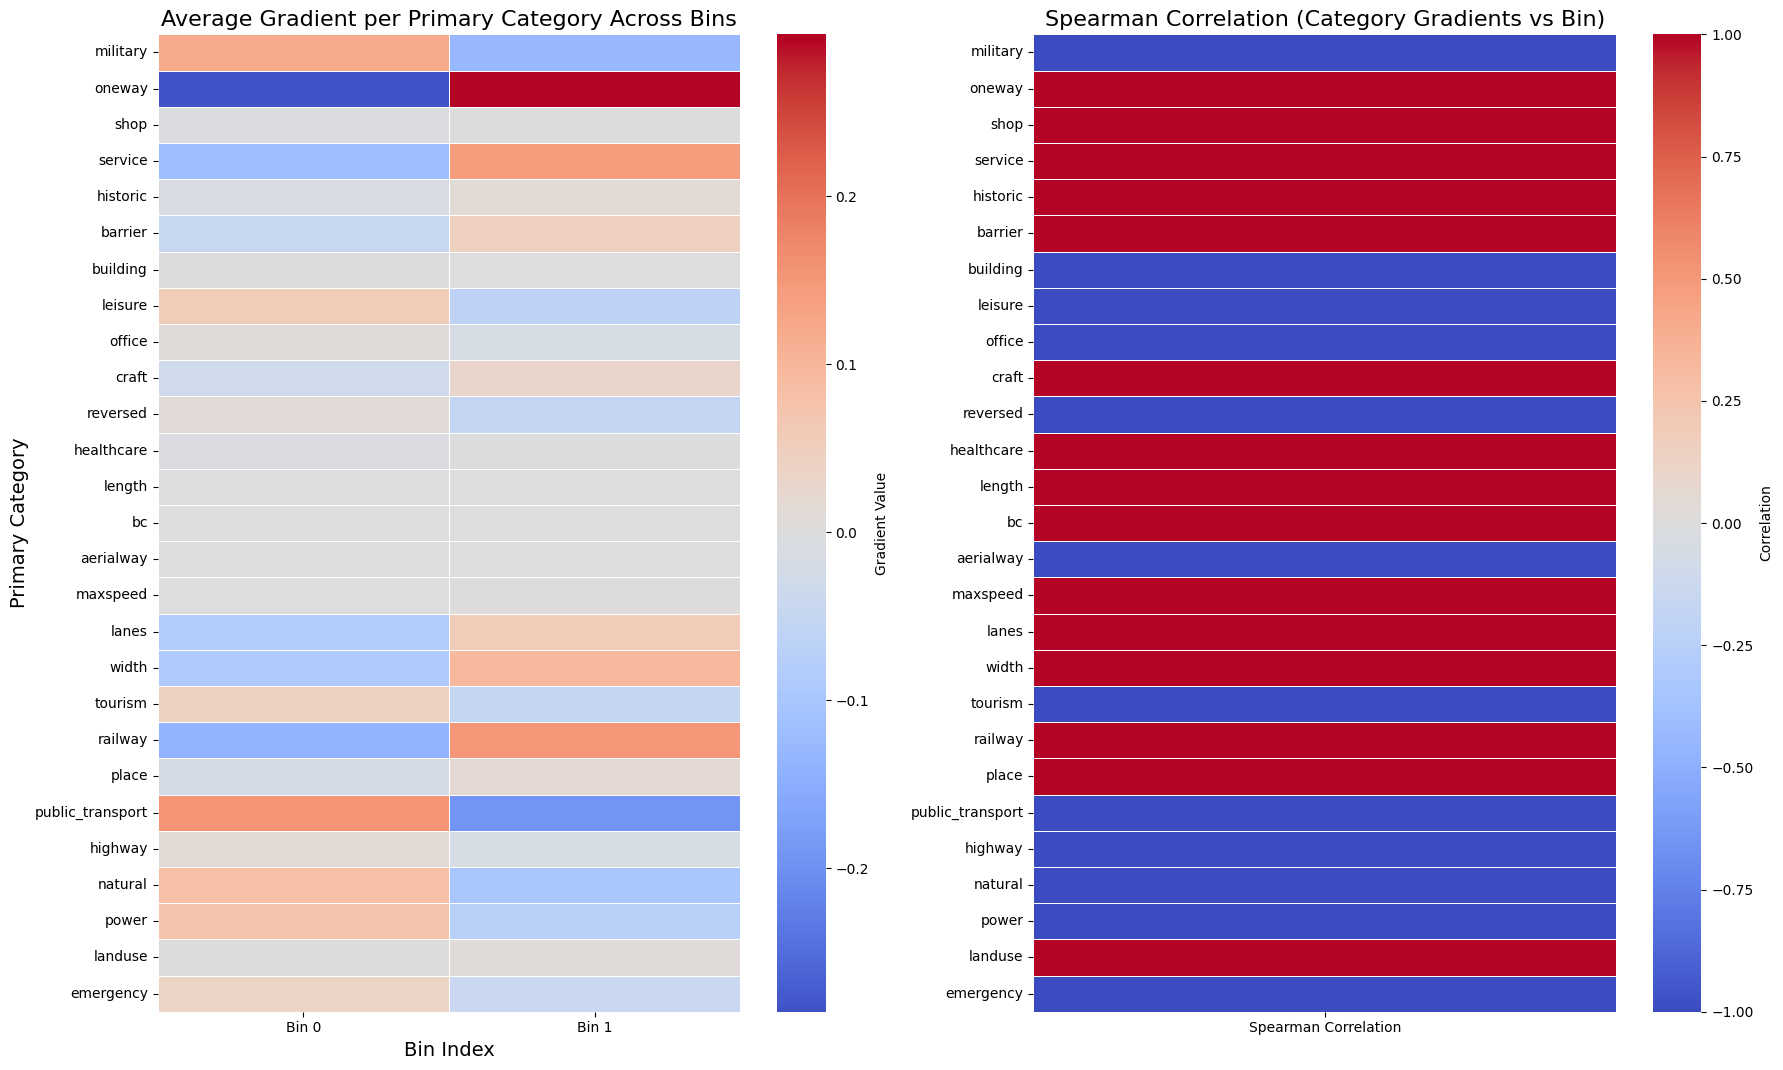

In [157]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import numpy as np

# 🧠 Step 1: Prepare the grouped summary_df
summary_grouped = summary_df.groupby('Primary_Category').agg({
    'Avg_Gradient': 'mean',
    'Gradient_Trend_Slope': 'mean'
}).sort_values('Avg_Gradient', ascending=False)

primary_categories = list(summary_grouped.index)

# 🧠 Step 2: Build grouped feature × bin matrix

# Initialize matrix (Primary Categories x Bins)
category_bin_gradients = np.zeros((len(primary_categories), len(bins) + 1))

for idx, category in enumerate(primary_categories):
    # Find all features belonging to this category
    features_in_cat = summary_df[summary_df['Primary_Category'] == category]['Feature'].values

    # For each feature, accumulate its bin gradients
    grads_list = []
    for feat_name in features_in_cat:
        feat_idx_in_feats_df = list(feats_df.columns).index(feat_name)
        if feat_idx_in_feats_df not in all_bin_grads_total:
            continue

        grads_across_nodes = np.stack(all_bin_grads_total[feat_idx_in_feats_df])  # (num_nodes x num_bins)
        avg_grads_per_bin = np.mean(grads_across_nodes, axis=0)  # (num_bins,)
        grads_list.append(avg_grads_per_bin)

    # Average over all features in the category
    if grads_list:
        grads_list = np.stack(grads_list)
        category_bin_gradients[idx, :] = grads_list.mean(axis=0)

# 🧠 Step 3: Compute Spearman correlation per category

spearman_corrs = []

for idx in range(category_bin_gradients.shape[0]):
    grads = category_bin_gradients[idx, :]
    bin_indices = np.arange(len(bins) + 1)

    if np.all(grads == 0):
        spearman_corr = 0.0
    else:
        spearman_corr, _ = spearmanr(bin_indices, grads)

    spearman_corrs.append(spearman_corr)

spearman_corrs = np.array(spearman_corrs)

# 🧠 Step 4: Plot side-by-side

fig, axes = plt.subplots(1, 2, figsize=(18, len(primary_categories) * 0.4))

# 🔥 Left: Gradients heatmap
sns.heatmap(
    category_bin_gradients,
    ax=axes[0],
    xticklabels=[f"Bin {i}" for i in range(len(bins)+1)],
    yticklabels=primary_categories,
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    cbar_kws={"label": "Gradient Value"}
)
axes[0].set_title("Average Gradient per Primary Category Across Bins", fontsize=16)
axes[0].set_xlabel("Bin Index", fontsize=14)
axes[0].set_ylabel("Primary Category", fontsize=14)

# 🔥 Right: Spearman correlation heatmap
sns.heatmap(
    spearman_corrs.reshape(-1, 1),
    ax=axes[1],
    yticklabels=primary_categories,
    xticklabels=["Spearman Correlation"],
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    cbar_kws={"label": "Correlation"}
)
axes[1].set_title("Spearman Correlation (Category Gradients vs Bin)", fontsize=16)
axes[1].set_xlabel("")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()


C:\Users\chris\AppData\Local\Temp\ipykernel_7816\2152824915.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


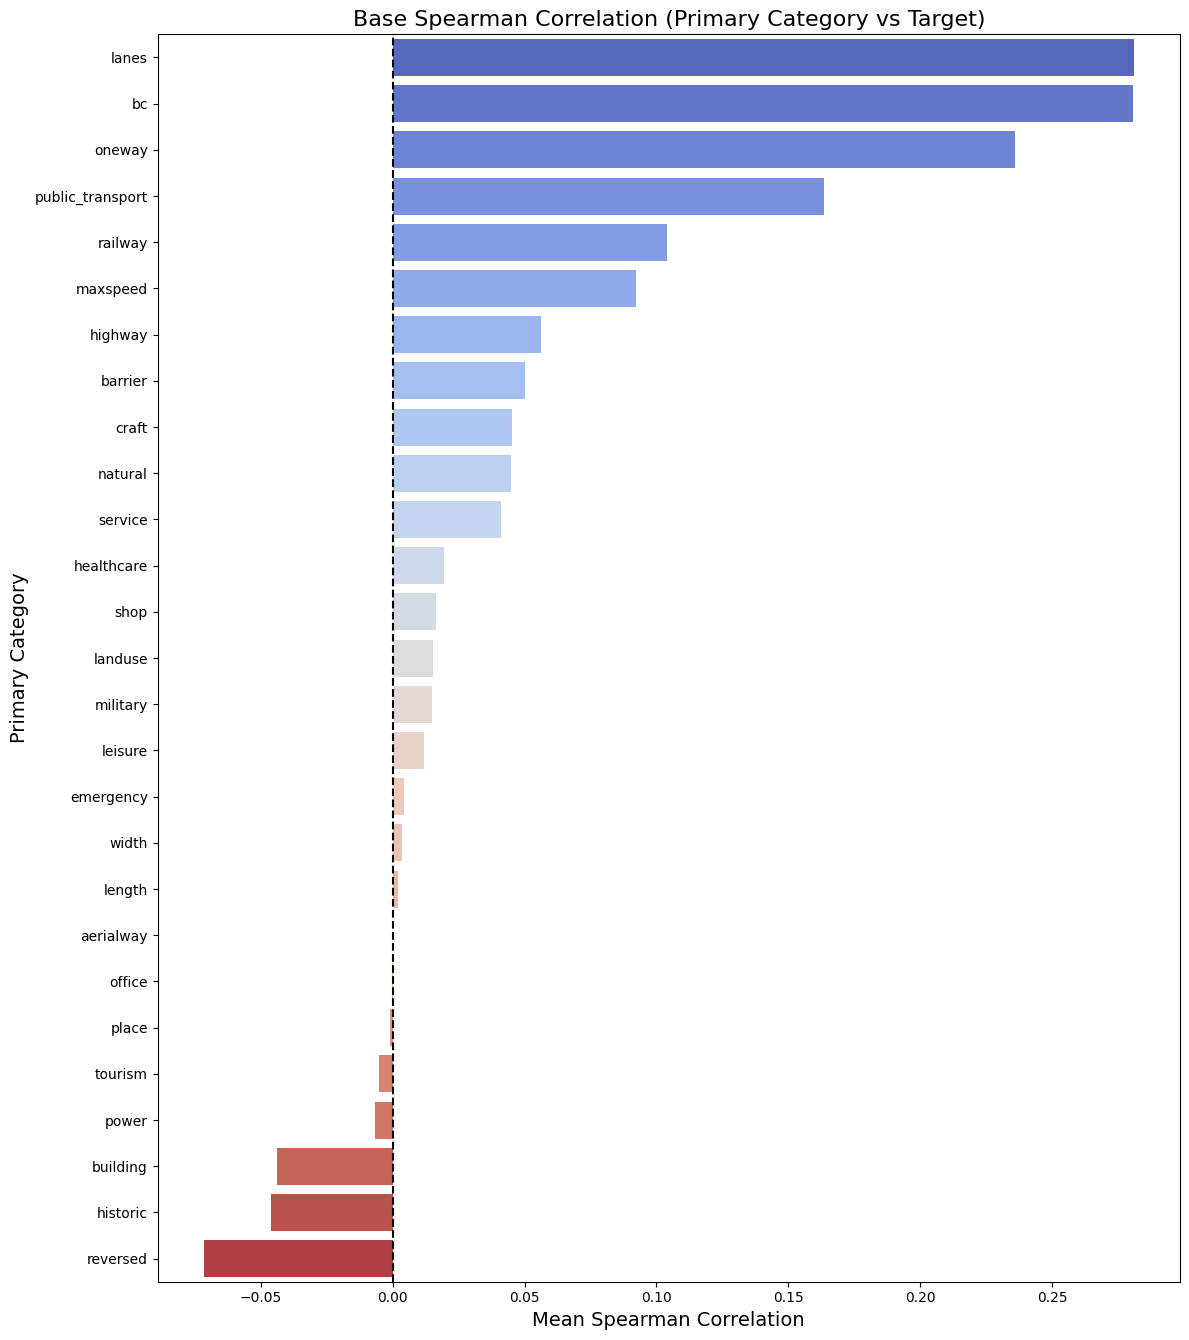

In [165]:
from scipy.stats import spearmanr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 🧠 Step 1: Prepare features and y

# Load feature data
X = pd.read_csv(f'../data/graphs/{graph_num}/node_features.csv')
if 'aadt' in X.columns:
    X = X.drop(columns=['aadt'])
y = data.y.cpu().numpy()  # Your original target values (unbinned)

# 🧠 Step 2: Mask X and y where y > 0
mask = y > 0
X_filtered = X.iloc[mask]
y_filtered = y[mask]

# 🧠 Step 3: Compute Spearman correlation for each feature vs. y_filtered
base_spearman_corrs = {}

for feat in X_filtered.columns:
    feature_values = X_filtered[feat].values

    if np.all(feature_values == feature_values[0]):
        corr = 0.0
    else:
        corr, _ = spearmanr(feature_values, y_filtered)

    base_spearman_corrs[feat] = corr

# 🧠 Step 4: Convert to DataFrame
base_corr_df = pd.DataFrame({
    'Feature': list(base_spearman_corrs.keys()),
    'Spearman_Feature_vs_Target': list(base_spearman_corrs.values())
})

# 🧠 Step 5: Merge in Primary Category information

# Assume you already have `summary_df` with Feature and Primary_Category
base_corr_df = base_corr_df.merge(summary_df[['Feature', 'Primary_Category']], on='Feature', how='left')

# 🧠 Step 6: Group by Primary Category
base_corr_grouped = base_corr_df.groupby('Primary_Category').agg({
    'Spearman_Feature_vs_Target': 'mean'
}).sort_values('Spearman_Feature_vs_Target', ascending=False)

base_corr_grouped['Abs_Spearman'] = base_corr_grouped['Spearman_Feature_vs_Target'].abs()

# 🧠 Step 7: Plot

plt.figure(figsize=(12, len(base_corr_grouped) * 0.5))  # Scale by number of groups

sns.barplot(
    data=base_corr_grouped.reset_index(),
    y='Primary_Category',
    x='Spearman_Feature_vs_Target',
    palette='coolwarm'
)

plt.axvline(0, color='black', linestyle='--')
plt.title('Base Spearman Correlation (Primary Category vs Target)', fontsize=16)
plt.xlabel('Mean Spearman Correlation', fontsize=14)
plt.ylabel('Primary Category', fontsize=14)
plt.tight_layout()
plt.show()


In [160]:
# used_feats = []
# scores = {}


# for i in node_idx:
#     # Input data must include x and edge_index, and optionally y
#     explanation = explainer(data.x.to(device), data.edge_index.to(device), index=i)
#     # Ensure node_mask is 2D
#     node_mask = explanation.node_mask
#     if node_mask.dim() == 1:
#         node_mask = node_mask.unsqueeze(0)
#     elif node_mask.dim() == 3:
#         node_mask = node_mask.squeeze(0)
    

#     curr_pred = pred[i].item()
#     target = data.y[i].item()
#     target = int(torch.bucketize(target, bins))

#     # Sum across nodes (or use first if only one node)
#     score = node_mask.sum(dim=0).detach().cpu().numpy()
#     score = score.flatten()  # ensure 1D

#     # Ensure labels are native Python list (not np array or tensor)
#     feat_labels = [f"feat_{i}" for i in range(score.shape[0])]
#     top10 = np.argsort(score)[::-1][:10]  # Get indices of top 10 features
#     top10_score = score[top10]  # Get scores of top 10 features
#     print(top10[top10_score > 0], top10_score[top10_score > 0], '\n PRedicted class:' ,curr_pred, 'actual class:', target, '\n---------------------------------------', flush = True)
#     for i in top10:
#         used_feats.append(i)
#         if i not in scores:
#             scores[i] = []
#         scores[i].append(score[i])


In [161]:
# from collections import Counter
# Counter(used_feats).most_common(100)


In [162]:
# for i in scores:
#     scores[i] = np.mean(scores[i])


In [163]:
# scores = dict(sorted(scores.items(), key=lambda item: item[1], reverse=True))


In [164]:
# scores
